In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
# tf.enable_eager_execution()
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
tfd = tensorflow_probability.distributions

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100]
rprob = 0.5
shape = (nc, nc, nc)

In [9]:
suff = 'pad2'
ftname = ['cic']
nchannels = len(ftname)


cube_size = 32
max_offset = ncp - cube_size
pad = 2
cube_sizeft = cube_size + 2*pad



In [6]:
meshes = {}
cube_features, cube_target = [], []
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    mesh['GD'] = mesh['R1'] - mesh['R2']
    mesh['s'] = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/s/')

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['target'] = hmesh['pnn'].copy()

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels                                                                                                                 
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['target']
    targetmesh[targetmesh > 1] = 1

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube)
    yinp = dtools.splitvoxels(targetmesh, cube_size=cube_size, shift=cube_size, ncube=ncube)
    mesh['inp'], mesh['yinp'] = inp, yinp
    
    meshes[seed] = [mesh, hmesh]

# features = np.stack(features, axis=0)
# target = np.stack(target, axis=0)



All the mesh have been generated for seed = 100


In [10]:
tf.reset_default_graph()

#                                                                                                                                           
niter = 9000
sess = tf.Session()
chkname = suff #+'_it%d'%niter                                                                                                              

path_savedat = './models/n%02d/%s/%s.hub'%(numd*1e4, suff, suff)
# saver = tf.train.import_meta_graph('./../code/models/n%02d/%s/%s.meta'%(numd*1e4, suff, chkname))


# Check module here

In [14]:
tf.reset_default_graph()
module = hub.Module('./models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname))
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
output = module(dict(input=xx, label=yy, keepprob=1), as_dict=True)['prediction']

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    for seed in seeds:
        inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
        recp = sess.run(output, feed_dict={xx:inp, yy:yinp})
        meshes[seed][0]['predict'] = dtools.uncubify(recp[:,:,:,:,0], shape)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(32, 32, 32) [128 128 128]


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


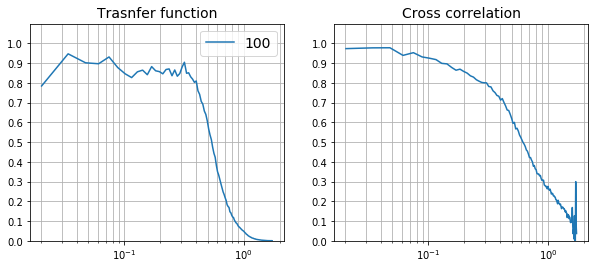

In [15]:
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for seed in seeds:
    predict, hpmeshd = meshes[seed][0]['predict'], meshes[seed][1]['target'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
    #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)                                                          
    #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)                                    

    ##                                                                                                                                      
    ax[0].semilogx(k, pkpred/pkhd, label=seed)
    ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
    # plt.plot(k, pkpredall/pkhd)                                                                                                           

ax[0].legend(fontsize=14)
ax[0].set_title('Trasnfer function', fontsize=14)
ax[1].set_title('Cross correlation', fontsize=14)
for axis in ax: axis.set_ylim(0., 1.1)
for axis in ax: axis.set_yticks(np.arange(0, 1.1, 0.1))
for axis in ax: axis.grid(which='both')


# Recon single voxel

In [16]:
##############################                                                                                                              
##MODEL HERE
#                                                                                                                                           
tf.reset_default_graph()
chkname = suff #+'_it%d'%niter                                                                                                              


module = hub.Module('./models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname))

#To predict                                                                                                                                 
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
output = module(dict(input=xx, label=yy, keepprob=1), as_dict=True)['prediction']
#To optimize                                                                                                                                
xopt = tf.get_variable(name='xopt', shape=[1, cube_sizeft, cube_sizeft, cube_sizeft, nchannels]
                       , initializer=tf.initializers.ones, trainable=True)
outputopt = module(dict(input=xopt, label=yy, keepprob=1))
loss = tf.losses.sigmoid_cross_entropy(yy, outputopt)

lr = tf.placeholder(tf.float32, name='learningrate')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss, var_list=[xopt])
# opt_op = optimizer.minimize(tf.reduce_sum(output))       

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [23]:
##Do optimization here

#Select data voxel
ind = np.random.randint(100)
inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
print('Index = %d'%ind)
recontruth = inp[ind:ind+1]
reconmapp = yinp[ind:ind+1]


#parameters
losses = []
niter, nprint = 10000, 1000
lr0, lrfac, nlr = 10, 10, int(10000)
lr0 *= lrfac
print('niter, lr0, lrfac, nlr : ', niter, lr0, lrfac, nlr)


#optimize
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    val0 = sess.run(xopt)
    start, curr = time(), time()

    for it in range(niter+1):
        _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, yy:reconmapp})
        if it % nlr == 0:
            lr0 /= lrfac
            print('reduce learning rate by factor of %0.2f. New learning rate = %0.2e'%(lrfac, lr0))

        if it % nprint == 0:
            end = time()
            print('Iter %d of %d : Loss= %0.4f\nTime taken for last batch = %0.3f, \
            \nTotal time elapsed = %0.3f'%(it, niter, l, end-curr, end - start))
            curr = end
        losses.append(l)


    #save reconstruced voxel
    recon = sess.run(xopt)
    outtruth = sess.run(output, feed_dict={xx:recontruth, yy:reconmapp})
    outrecon = sess.run(output, feed_dict={xx:recon, yy:reconmapp})



Index = 56
niter, lr0, lrfac, nlr :  10000 100 10 10000
reduce learning rate by factor of 10.00. New learning rate = 1.00e+01
Iter 0 of 10000 : Loss= 0.2954
Time taken for last batch = 1.575,             Total time elapsed = 1.575
Iter 1000 of 10000 : Loss= 0.1655
Time taken for last batch = 18.618,             Total time elapsed = 20.193
Iter 2000 of 10000 : Loss= 0.1651
Time taken for last batch = 18.690,             Total time elapsed = 38.883
Iter 3000 of 10000 : Loss= 0.1647
Time taken for last batch = 18.686,             Total time elapsed = 57.569
Iter 4000 of 10000 : Loss= 0.1644
Time taken for last batch = 18.683,             Total time elapsed = 76.252
Iter 5000 of 10000 : Loss= 0.1640
Time taken for last batch = 18.667,             Total time elapsed = 94.919
Iter 6000 of 10000 : Loss= 0.1636
Time taken for last batch = 18.622,             Total time elapsed = 113.541
Iter 7000 of 10000 : Loss= 0.1633
Time taken for last batch = 18.666,             Total time elapsed = 132.2

Text(0, 0.5, 'Halo (Recon Point)')

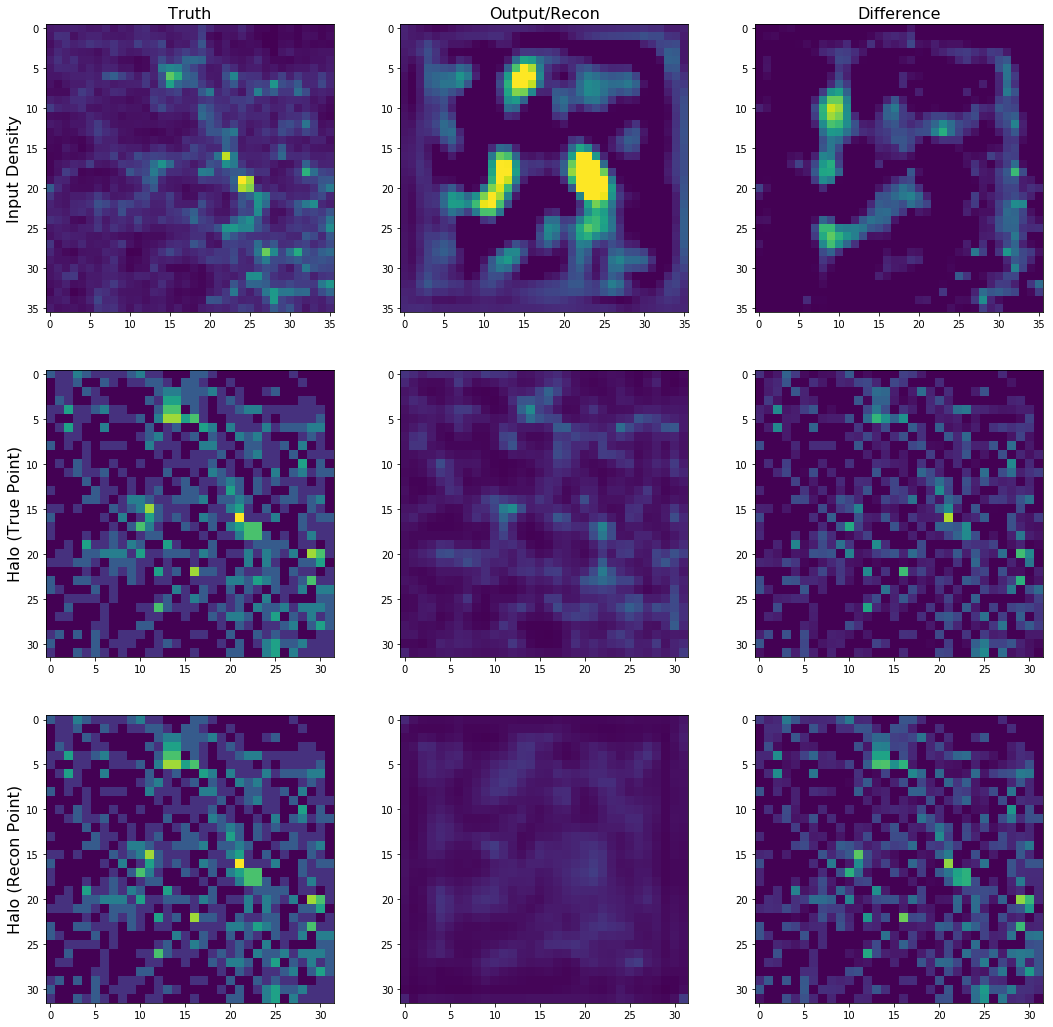

In [24]:
def getim(ar, axis=0):
    return ar[0, :, :, :, 0].sum(axis=axis)

fig, axar = plt.subplots(3, 3, figsize=(18, 18))

fsize = 16
ax = axar[0]
vmin, vmax = getim(recontruth).min(), getim(recontruth).max()
ax[0].imshow(getim(recontruth), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(recon), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(recontruth-recon), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Input Density', fontsize=fsize)
ax[0].set_title('Truth', fontsize=fsize)
ax[1].set_title('Output/Recon', fontsize=fsize)
ax[2].set_title('Difference', fontsize=fsize)

ax = axar[1]
vmin, vmax = getim(reconmapp).min(), getim(reconmapp).max()
ax[0].imshow(getim(reconmapp), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(outtruth), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(reconmapp-outtruth), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Halo (True Point)', fontsize=fsize)

ax = axar[2]
vmin, vmax = getim(reconmapp).min(), getim(reconmapp).max()
ax[0].imshow(getim(reconmapp), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(outrecon), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(reconmapp-outrecon), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Halo (Recon Point)', fontsize=fsize)



# Recon whole box

In [27]:
##############################
##MODEL HERE
#         
inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']

##

tf.reset_default_graph()
sess = tf.Session()
chkname = suff #+'_it%d'%niter 

module = hub.Module('./models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname))
#To predict
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
output = module(dict(input=xx, label=yy, keepprob=1), as_dict=True)['prediction']
#To optimize
xopt = tf.get_variable(name='xopt', shape=[nsize, cube_sizeft, cube_sizeft, cube_sizeft, nchannels]
                       , initializer=tf.initializers.ones, trainable=True)
outputopt = module(dict(input=xopt, label=yy, keepprob=1))
loss = tf.losses.sigmoid_cross_entropy(yy, outputopt)

lr = tf.placeholder(tf.float32, name='learningrate')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss, var_list=[xopt])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [30]:
##Do optimization here

#Generate data
inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
shape = (nc, nc, nc)

losses = []
niter, nprint = 100, 100
lr0, lrfac, nlr = 10, 10, int(10000)
lr0 *= lrfac

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    val0 = sess.run(xopt)
    start, curr = time(), time()

    for it in range(niter+1):
        _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, yy:yinp})
        if it % nlr == 0:
            lr0 /= lrfac
            print('reduce learning rate by factor of %0.2f. New learning rate = %0.2e'%(lrfac, lr0))

        if it % nprint == 0:
            end = time()
            print('Iter %d of %d : Loss= %0.4f\nTime taken for last batch = %0.3f,\
            \nTotal time elapsed = %0.3f'%(it, niter, l, end-curr, end - start))
            curr = end
            #loss     
        losses.append(l)

    recon = sess.run(xopt)
    outtruth = sess.run(output, feed_dict={xx:inp, yy:yinp})
    outrecon = sess.run(output, feed_dict={xx:recon, yy:yinp})


reduce learning rate by factor of 10.00. New learning rate = 1.00e+01
Iter 0 of 100 : Loss= 0.2511
Time taken for last batch = 44.255,            Total time elapsed = 44.255
Iter 100 of 100 : Loss= 0.1393
Time taken for last batch = 77.487,            Total time elapsed = 121.742


In [34]:
#Reshape data to the correct mesh
recon = dtools.uncubify(recon[:, 2:34, 2:34, 2:34, 0], shape)
outtruth = dtools.uncubify(outtruth[:, :, :, :, 0], shape)
outrecon = dtools.uncubify(outrecon[:, :, :, :, 0], shape)

reconmapp = dtools.uncubify(yinp[:, :, :, :, 0], shape)
recontruth = dtools.uncubify(inp[:, 2:34, 2:34, 2:34, 0], shape)


(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]


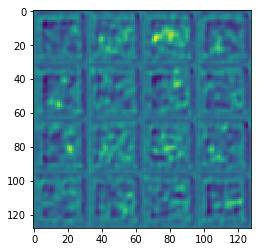

In [36]:
plt.imshow(recon.sum(axis=0))

Text(0, 0.5, 'Halo (Recon Point)')

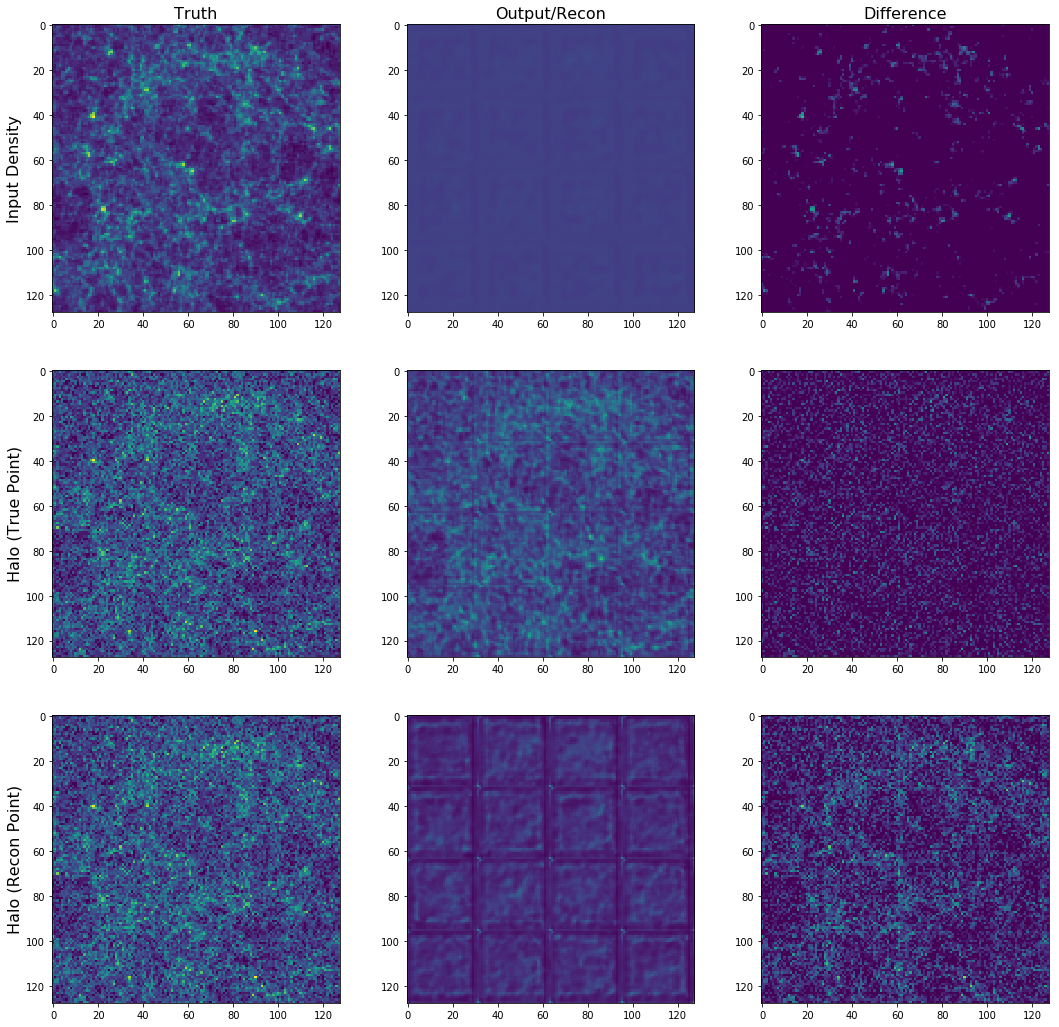

In [37]:

def getim(ar, axis=0):
    #return ar[0, :, :, :, 0].sum(axis=axis)                                                                                                
    return ar[:, :, :].sum(axis=axis)

fig, axar = plt.subplots(3, 3, figsize=(18, 18))

fsize = 16
ax = axar[0]
vmin, vmax = getim(recontruth).min(), getim(recontruth).max()
ax[0].imshow(getim(recontruth), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(recon), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(recontruth-recon), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Input Density', fontsize=fsize)
ax[0].set_title('Truth', fontsize=fsize)
ax[1].set_title('Output/Recon', fontsize=fsize)
ax[2].set_title('Difference', fontsize=fsize)

ax = axar[1]
vmin, vmax = getim(reconmapp).min(), getim(reconmapp).max()
ax[0].imshow(getim(reconmapp), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(outtruth), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(reconmapp-outtruth), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Halo (True Point)', fontsize=fsize)

ax = axar[2]
vmin, vmax = getim(reconmapp).min(), getim(reconmapp).max()
ax[0].imshow(getim(reconmapp), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(outrecon), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(reconmapp-outrecon), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Halo (Recon Point)', fontsize=fsize)
